
--- Classification Model: Random Forest ---

Classification Report for Collision Severity (Random Forest):
              precision    recall  f1-score   support

       Fatal       0.00      0.00      0.00        16
   No Injury       0.89      0.79      0.84      6337
   Non-Fatal       0.24      0.41      0.30      1012

    accuracy                           0.74      7365
   macro avg       0.38      0.40      0.38      7365
weighted avg       0.80      0.74      0.76      7365



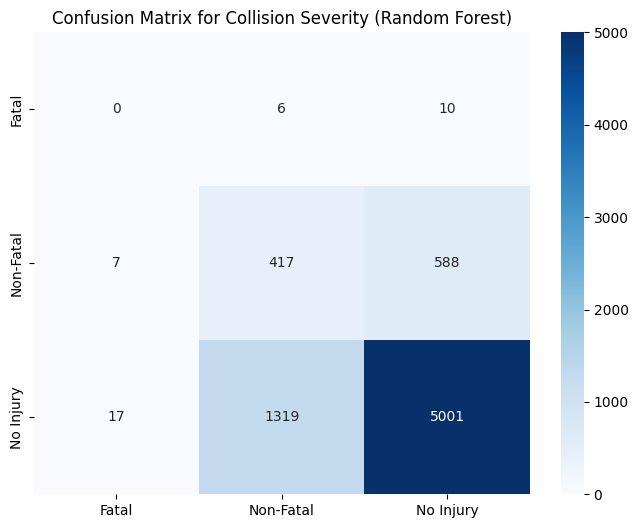

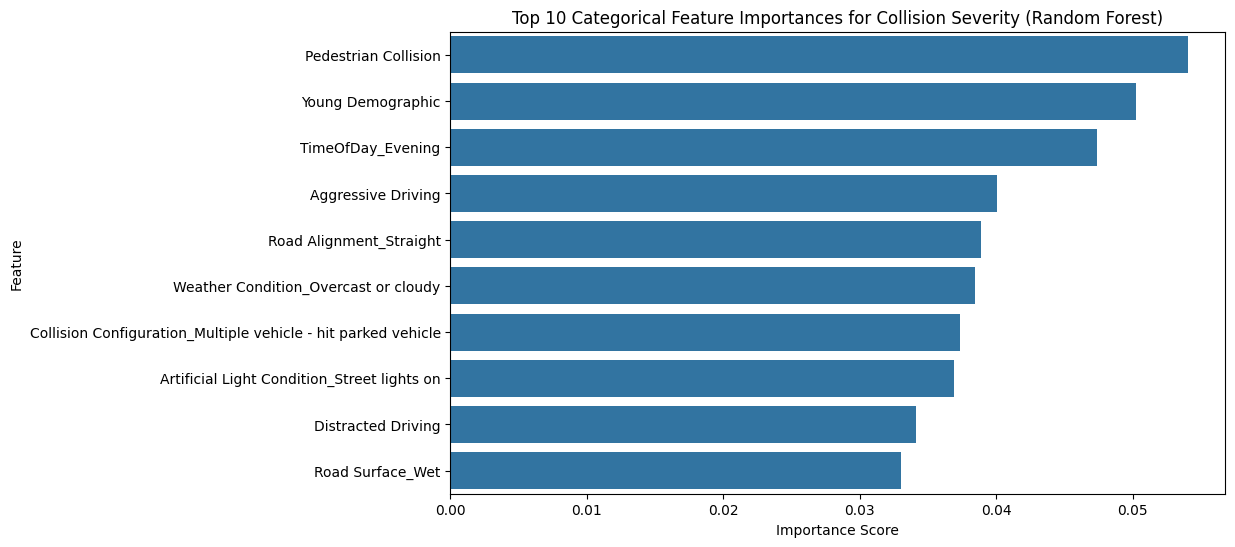

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('/content/drive/MyDrive/HRM/Processed_Traffic_Collision.csv')

# --- Classification Preparation ---
# Encode binary variables (Y/N to 1/0)
binary_cols = ['Young Demographic', 'Pedestrian Collision', 'Aggressive Driving',
               'Distracted Driving', 'Impaired Driving', 'Bicycle Collision',
               'Intersection Collision', 'School Purpose Related']
for col in binary_cols:
    df[col] = df[col].map({'Y': 1, 'N': 0})

# One-hot encode categorical variables, excluding spatial and temporal features
categorical_cols = ['Road Configuration', 'Collision Configuration', 'Light Condition',
                    'Artificial Light Condition', 'Weather Condition', 'Road Surface',
                    'Road Condition', 'Road Alignment', 'Road Grade', 'TimeOfDay']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Features and target for classification (exclude spatial/temporal and Risk Score related columns)
X_clf = df_encoded.drop(columns=['OBJECTID', 'COLLISION_SK', 'Accident Date and Time',
                                'Road Location', 'Intersecting Road Location',
                                'Unusual Environmental Circumstances 1',
                                'Unusual Environmental Circumstances 2',
                                'Collision Severity', 'Non Fatal Injury', 'Fatal Injury',
                                'Latitude WGS84', 'Longitude WGS84', 'Hour', 'Year', 'Month', 'Day']) # Exclude Risk_Score here as it's target for forecasting
y_clf = df_encoded['Collision Severity']

# Split data for classification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, stratify=y_clf, random_state=42)

# --- Classification Model: Random Forest ---
print("\n--- Classification Model: Random Forest ---")
class_weights = {'Fatal': 100, 'Non-Fatal': 10, 'No Injury': 1}
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
rf_clf.fit(X_train_clf, y_train_clf)

# Predict and evaluate classification - Random Forest
y_pred_clf_rf = rf_clf.predict(X_test_clf)
print("\nClassification Report for Collision Severity (Random Forest):")
print(classification_report(y_test_clf, y_pred_clf_rf))

# Confusion matrix - Random Forest
cm_rf = confusion_matrix(y_test_clf, y_pred_clf_rf, labels=['Fatal', 'Non-Fatal', 'No Injury'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Fatal', 'Non-Fatal', 'No Injury'],
            yticklabels=['Fatal', 'Non-Fatal', 'No Injury'])
plt.title('Confusion Matrix for Collision Severity (Random Forest)')
plt.show()

# Feature importance for categorical features only (excluding spatial/temporal) - Random Forest
importances_rf = rf_clf.feature_importances_
feature_names_rf = X_train_clf.columns
importance_df_rf = pd.DataFrame({'Feature': feature_names_rf, 'Importance': importances_rf})

# Filter for categorical features only (binary and one-hot encoded) - Random Forest
categorical_features_rf = []
for col in importance_df_rf['Feature']:
    if any(cat in col for cat in categorical_cols + binary_cols):
        categorical_features_rf.append(col)

categorical_importance_rf = importance_df_rf[importance_df_rf['Feature'].isin(categorical_features_rf)]
categorical_importance_rf = categorical_importance_rf.sort_values('Importance', ascending=False)

# Visualize top 10 categorical feature importances for stakeholders - Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=categorical_importance_rf.head(10))
plt.title('Top 10 Categorical Feature Importances for Collision Severity (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [ ]:
# --- Forecasting Preparation ---
# Calculate Risk-score per collision
df['Risk_Score'] = np.where(df['Collision Severity'] == 'Fatal', 10,
                           np.where(df['Collision Severity'] == 'Non-Fatal', 5, 0))

# Aggregate to monthly risk scores
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
monthly_risk = df.groupby('Date')['Risk_Score'].sum().reset_index()
monthly_risk = monthly_risk.set_index('Date') # Set Date as index for time series analysis
ts_data_risk_score = monthly_risk['Risk_Score']

# --- Time Series Analysis and Forecasting: SARIMA for Risk Score ---
print("\n--- Time Series Forecasting: SARIMA for Risk Score ---")


--- Time Series Forecasting: SARIMA for Risk Score ---


In [ ]:
# 1. Check Stationarity of Risk Score Time Series
print("\nChecking stationarity of Risk Score time series:")
result = adfuller(ts_data_risk_score.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Difference the time series to achieve stationarity if needed (example: first order differencing)
ts_data_risk_score_diff = ts_data_risk_score.diff().dropna()

print("\nChecking stationarity after differencing:")
result_diff = adfuller(ts_data_risk_score_diff.dropna())
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))



Checking stationarity of Risk Score time series:
ADF Statistic: -5.406452
p-value: 0.000003
Critical Values:
	1%: -3.514
	5%: -2.898
	10%: -2.586

Checking stationarity after differencing:
ADF Statistic: -5.737309
p-value: 0.000001
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589


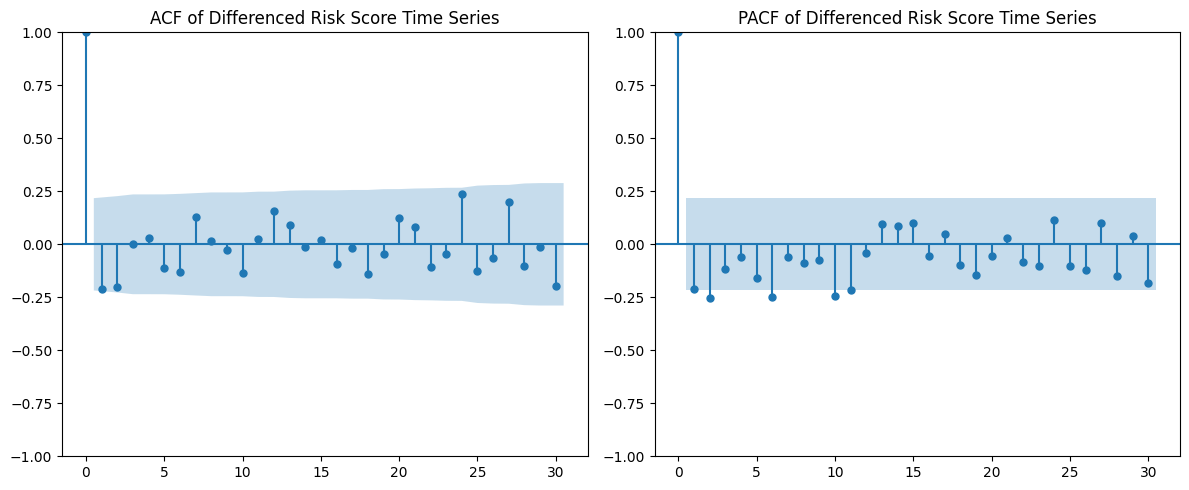

In [ ]:
# 2. Plot ACF and PACF to determine ARIMA orders (after differencing if needed)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(ts_data_risk_score_diff, ax=plt.gca(), lags=30) # Use differenced data for ACF/PACF
plt.title('ACF of Differenced Risk Score Time Series')
plt.subplot(122)
plot_pacf(ts_data_risk_score_diff, ax=plt.gca(), lags=30) # Use differenced data for ACF/PACF
plt.title('PACF of Differenced Risk Score Time Series')
plt.tight_layout()
plt.show()

In [ ]:
# 3. Fit SARIMA model (adjust order and seasonal_order based on ACF/PACF and stationarity tests)
# Example parameters - you might need to tune these based on your ACF/PACF plots and data characteristics
order = (1, 1, 1) # (p, d, q) - after differencing once (d=1)
seasonal_order = (1, 1, 1, 12) # (P, D, Q, s) - yearly seasonality (s=12), differencing seasonality once (D=1)

sarima_model_risk_score = SARIMAX(ts_data_risk_score,
                                  order=order,
                                  seasonal_order=seasonal_order,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
sarima_results_risk_score = sarima_model_risk_score.fit(disp=False)
print("\nSARIMA Model Summary for Risk Score Forecasting:")
print(sarima_results_risk_score.summary())


SARIMA Model Summary for Risk Score Forecasting:
                                     SARIMAX Results                                      
Dep. Variable:                         Risk_Score   No. Observations:                   82
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -304.619
Date:                            Mon, 03 Mar 2025   AIC                            619.238
Time:                                    03:03:05   BIC                            629.275
Sample:                                01-01-2018   HQIC                           623.120
                                     - 10-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5440      0.134      4.054      0.000       0.2

In [ ]:
# 4. Forecasting Risk Score
forecast_steps = 24 # Forecast for the next 24 months
sarima_forecast_risk_score = sarima_results_risk_score.get_forecast(steps=forecast_steps)
sarima_mean_risk_score = sarima_forecast_risk_score.predicted_mean
sarima_ci_risk_score = sarima_forecast_risk_score.conf_int()


In [ ]:
# 5. Evaluate Forecasting (using test set if you have a hold-out period, or in-sample fit metrics)
# For simplicity, we'll evaluate in-sample fit and visualize forecast vs actuals.
# In a real scenario, you would split your time series data into train/test for proper evaluation.

# Create a forecast dataframe
sarima_forecast_df_risk_score = pd.DataFrame({
    'Forecast': sarima_mean_risk_score,
    'Lower CI': sarima_ci_risk_score.iloc[:, 0],
    'Upper CI': sarima_ci_risk_score.iloc[:, 1]
}, index=pd.date_range(ts_data_risk_score.index[-1], periods=forecast_steps, freq='MS')) # Monthly frequency, starting after last date

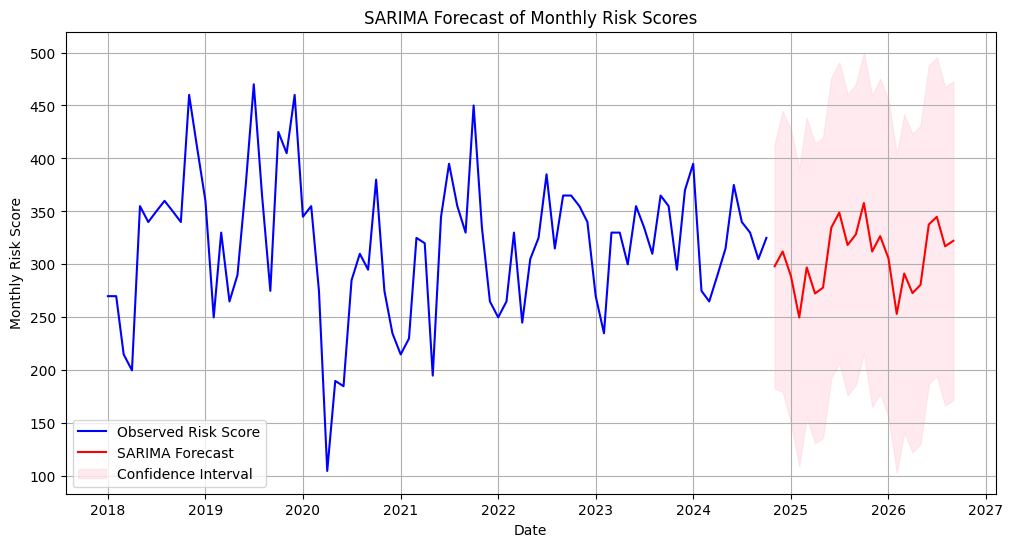

In [ ]:
# 6. Plot Forecasted Risk Scores with SARIMA
plt.figure(figsize=(12, 6))
plt.plot(ts_data_risk_score.index, ts_data_risk_score, label='Observed Risk Score', color='blue') # Plot observed Risk Score
plt.plot(sarima_forecast_df_risk_score.index, sarima_forecast_df_risk_score['Forecast'], label='SARIMA Forecast', color='red') # Plot SARIMA forecast
plt.fill_between(sarima_forecast_df_risk_score.index, sarima_forecast_df_risk_score['Lower CI'], sarima_forecast_df_risk_score['Upper CI'],
                 color='pink', alpha=0.3, label='Confidence Interval') # Plot confidence interval

plt.title('SARIMA Forecast of Monthly Risk Scores')
plt.xlabel('Date')
plt.ylabel('Monthly Risk Score')
plt.legend()
plt.grid(True)
plt.show()


--- Forecasting Model: Random Forest Regressor for Risk Score ---

Random Forest Forecasting Evaluation - MAE: 28.50, RMSE: 37.29


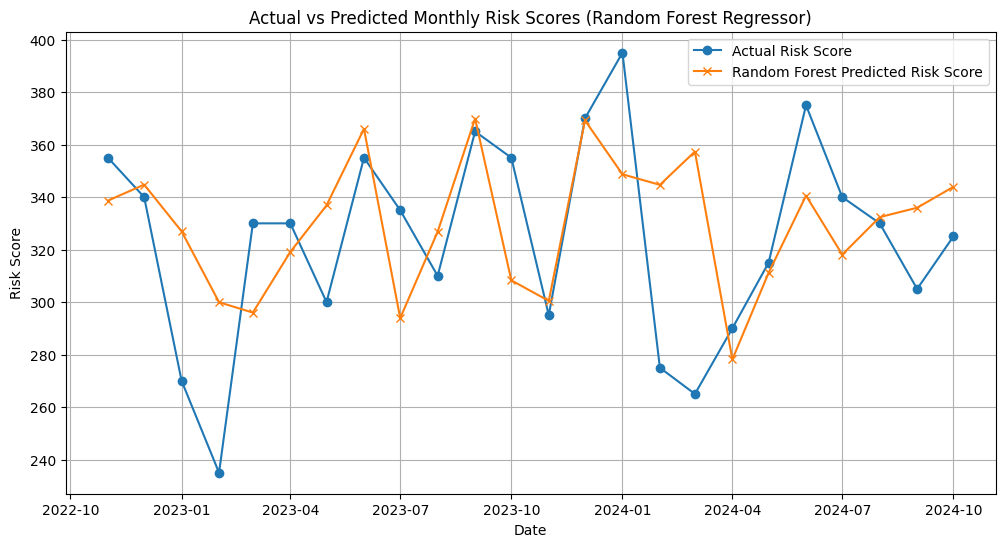

In [ ]:
# --- Forecasting with Random Forest Regressor for Comparison ---
print("\n--- Forecasting Model: Random Forest Regressor for Risk Score ---")

# Prepare data for Random Forest Regressor (using lagged and rolling features as in Grok idea)
monthly_risk['Lag1'] = monthly_risk['Risk_Score'].shift(1)
monthly_risk['Rolling3'] = monthly_risk['Risk_Score'].rolling(window=3).mean()
monthly_risk = monthly_risk.dropna()

# Split data for forecasting (time-based split - using last 24 months as test set for comparison with SARIMA forecast horizon)
train_forecast_rf = monthly_risk[:-forecast_steps] # Training data up to the point before forecast period
test_forecast_rf = monthly_risk[-forecast_steps:] # Test data for evaluation

X_train_ts_rf = train_forecast_rf[['Lag1', 'Rolling3']]
y_train_ts_rf = train_forecast_rf['Risk_Score']
X_test_ts_rf = test_forecast_rf[['Lag1', 'Rolling3']]
y_test_ts_rf = test_forecast_rf['Risk_Score']

# Train Random Forest Regressor for forecasting
rf_reg_risk_score = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg_risk_score.fit(X_train_ts_rf, y_train_ts_rf)

# Predict and evaluate forecasting - Random Forest Regressor
y_pred_ts_rf = rf_reg_risk_score.predict(X_test_ts_rf)
mae_rf = mean_absolute_error(y_test_ts_rf, y_pred_ts_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_ts_rf, y_pred_ts_rf))
print(f'\nRandom Forest Forecasting Evaluation - MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}')


# Plot actual vs predicted for test period - Random Forest Regressor
plt.figure(figsize=(12, 6))
plt.plot(test_forecast_rf.index, y_test_ts_rf, label='Actual Risk Score', marker='o') # Actual risk score in test set
plt.plot(test_forecast_rf.index, y_pred_ts_rf, label='Random Forest Predicted Risk Score', marker='x') # RF predicted risk score
plt.title('Actual vs Predicted Monthly Risk Scores (Random Forest Regressor)')
plt.xlabel('Date')
plt.ylabel('Risk Score')
plt.legend()
plt.grid(True)
plt.show()


--- Forecasting Model: Random Forest Regressor for Risk Score ---
Updated Forecasted Monthly Risk Scores (2025-2026):
         Date  Random Forest Forecast
0  2024-11-01                  339.05
1  2024-12-01                  324.55
2  2025-01-01                  339.05
3  2025-02-01                  330.25
4  2025-03-01                  335.20
5  2025-04-01                  324.35
6  2025-05-01                  362.10
7  2025-06-01                  288.60
8  2025-07-01                  344.95
9  2025-08-01                  339.90
10 2025-09-01                  324.05
11 2025-10-01                  368.25


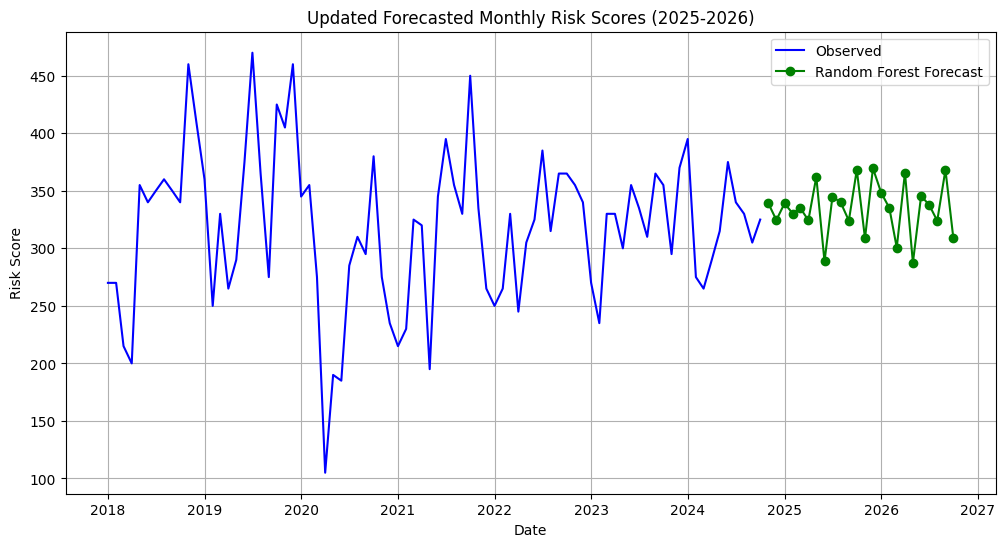

In [ ]:
# --- Forecasting Model: Random Forest Regressor for Risk Score ---
print("\n--- Forecasting Model: Random Forest Regressor for Risk Score ---")

# Aggregate to monthly risk scores
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
monthly_risk = df.groupby('Date')['Risk_Score'].sum().reset_index()

# Forecast future periods (2025-2026)
future_dates = pd.date_range(start='2024-10-31', end='2026-10-31', freq='MS')
future_df = pd.DataFrame(index=future_dates)
future_df['Lag1'] = monthly_risk['Risk_Score'].iloc[-1]  # Start with last known value
future_df['Rolling3'] = monthly_risk['Risk_Score'].rolling(window=3).mean().iloc[-1]  # Last rolling mean

forecast = []
last_pred = monthly_risk['Risk_Score'].iloc[-1]
for i in range(len(future_df)):
    pred = rf_reg.predict(future_df[['Lag1', 'Rolling3']].iloc[i:i+1])[0]
    forecast.append(pred)
    if i + 1 < len(future_df):
        future_df['Lag1'].iloc[i + 1] = pred  # Update Lag1
        future_df['Rolling3'].iloc[i + 1] = np.mean(forecast[-3:]) if len(forecast) >= 3 else future_df['Rolling3'].iloc[i]

# Create forecast DataFrame
forecast_df = pd.DataFrame({'Date': future_dates, 'Random Forest Forecast': forecast})
print("Updated Forecasted Monthly Risk Scores (2025-2026):")
print(forecast_df.head(12))  # Show first year for brevity

# Plot updated forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_risk['Date'], monthly_risk['Risk_Score'], label='Observed', color='blue')
plt.plot(future_df.index, forecast, label='Random Forest Forecast', marker='o', color='green')
plt.title('Updated Forecasted Monthly Risk Scores (2025-2026)')
plt.xlabel('Date')
plt.ylabel('Risk Score')
plt.legend()
plt.grid(True)
plt.show()


--- Comparing Forecasting Models Side-by-Side ---


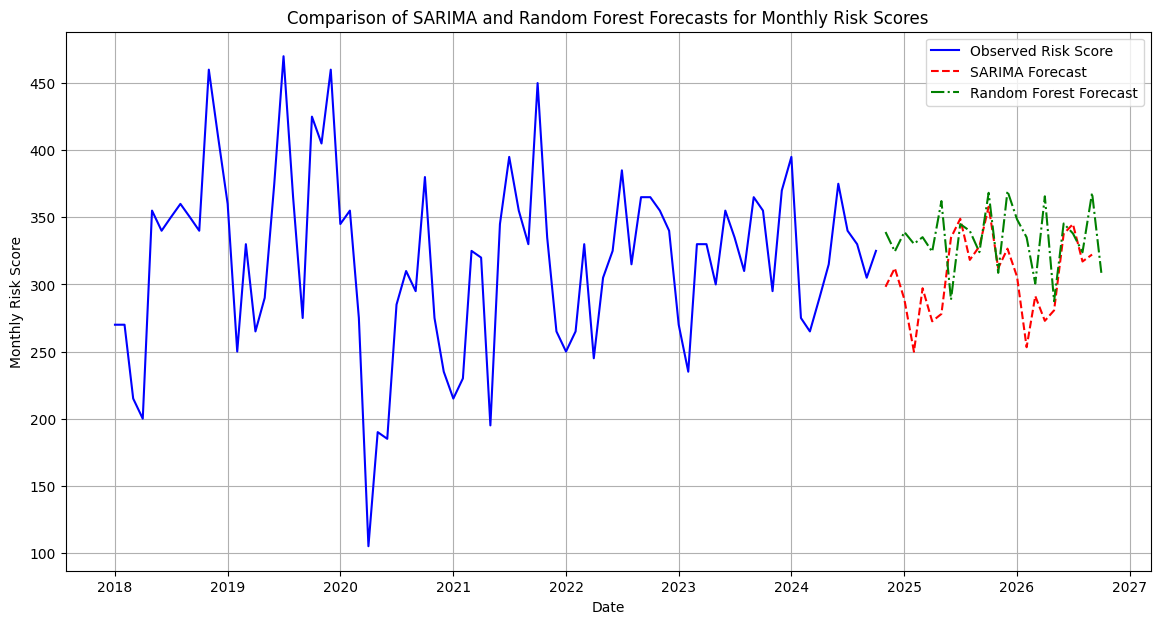

In [ ]:
# --- Compare Forecasting Models Side-by-Side ---
print("\n--- Comparing Forecasting Models Side-by-Side ---")

# Make predictions for the test set using the fitted Random Forest Regressor
y_pred_reg_rf_test = rf_reg_risk_score.predict(X_test_ts_rf) # Assuming rf_reg_risk_score is your fitted regressor

# Create a combined dataframe for plotting - SARIMA forecast already has date index
rf_forecast_df = pd.DataFrame({'Random Forest Forecast': y_pred_reg_rf_test}, index=test_forecast_rf.index)  # Using test_forecast_rf.index as DatetimeIndex

# Resample RF forecast to monthly if needed to align with SARIMA
rf_forecast_monthly = rf_forecast_df.resample('MS').mean() # Resample to Monthly, take mean if needed

# Align indices if necessary
sarima_forecast_df_risk_score_aligned = sarima_forecast_df_risk_score.reindex(rf_forecast_monthly.index, method='nearest')

# Plotting Side-by-Side Comparison
plt.figure(figsize=(14, 7))
plt.plot(ts_data_risk_score.index, ts_data_risk_score, label='Observed Risk Score', color='blue')
plt.plot(sarima_forecast_df_risk_score.index, sarima_forecast_df_risk_score['Forecast'], label='SARIMA Forecast', color='red', linestyle='--')
# Use forecast_df for the Random Forest Forecast
plt.plot(forecast_df['Date'], forecast_df['Random Forest Forecast'], label='Random Forest Forecast', color='green', linestyle='-.')
plt.legend()
plt.title('Comparison of SARIMA and Random Forest Forecasts for Monthly Risk Scores')
plt.xlabel('Date')
plt.ylabel('Monthly Risk Score')
plt.grid(True)
plt.show()

In [ ]:
# --- Compare Forecasting Models ---
print("\n--- Comparing Forecasting Models ---")
print("\nForecasting Evaluation for Random Forest Regressor:")
print(f'MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}')

# 1. Split time series data into train/test for SARIMA
# Using the last 24 months as the test set for consistency with Random Forest
train_data = ts_data_risk_score[:-24]
test_data = ts_data_risk_score[-24:]

# 2. Define the order and seasonal_order (keep your existing parameters)
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# 3. Fit SARIMA model on the training set
sarima_model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
sarima_results = sarima_model.fit()

# 4. Generate predictions for the test set
# Use get_prediction instead of get_predictions
sarima_predictions = sarima_results.get_prediction(start=test_data.index[0], end=test_data.index[-1])
predicted_mean = sarima_predictions.predicted_mean

# 5. Calculate MAE and RMSE for SARIMA on the test set
from sklearn.metrics import mean_absolute_error, mean_squared_error # Import if not already imported
mae_sarima = mean_absolute_error(test_data, predicted_mean)
rmse_sarima = np.sqrt(mean_squared_error(test_data, predicted_mean))

# 6. Print SARIMA evaluation metrics
print(f'\nSARIMA Forecasting Evaluation - MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}')


--- Comparing Forecasting Models ---

Forecasting Evaluation for Random Forest Regressor:
MAE: 28.50, RMSE: 37.29

SARIMA Forecasting Evaluation - MAE: 50.05, RMSE: 60.63


Based on the forecasting evaluation, the Random Forest Regressor outperforms the SARIMA model in predicting Risk Score, achieving a lower Mean Absolute Error (MAE) of 28.50 and Root Mean Squared Error (RMSE) of 37.29 compared to SARIMA's MAE of 50.05 and RMSE of 60.63. This suggests that for this specific dataset and forecasting task, the Random Forest Regressor, leveraging features beyond time series components, provides more accurate predictions than the SARIMA model.